In [1]:
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [2]:
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, lbl_min, lbl_max):
        """
        images: (N, 500, 500) numpy array, raw pixel values (0~4095)
        labels: (N,) numpy array, raw labels
        lbl_min, lbl_max: 레이블 Min–Max 정규화 상수
        """
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.lbl_min = lbl_min
        self.lbl_max = lbl_max
        self.to_tensor = T.ToTensor()  # (H, W) → (1, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]   # (500, 500)
        lbl = self.labels[idx]   # float

        # 1) [0,4095] → [0,1]
        img_norm = img / 4095.0

        # 2) Grayscale → Tensor (1, 500, 500)
        img_tensor = self.to_tensor(img_norm)

        # 3) 레이블 Min–Max 정규화 → [-1,1]
        lbl_norm = (lbl - self.lbl_min) / (self.lbl_max - self.lbl_min + 1e-8)  # [0,1]
        lbl_scaled = lbl_norm * 2.0 - 1.0                                       # [-1,1]
        lbl_tensor = torch.tensor(lbl_scaled, dtype=torch.float32)

        return img_tensor, lbl_tensor

In [3]:
class ViT50_3block(nn.Module):
    def __init__(self,
                 img_size=500,
                 patch_size=50,
                 embed_dim=256,
                 depth=3,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=1):
        """
        img_size: 입력 이미지 해상도 (여기서는 500×500)
        patch_size: 각 패치 크기 (50×50)
        embed_dim: 패치 임베딩 차원(여기선 256)
        depth: Transformer Encoder 레이어 개수 (3개)
        num_heads: 멀티헤드 어텐션 헤드 수 (8개)
        mlp_dim: Transformer 내부 MLP 숨겨진 차원 (512)
        num_classes: 출력 노드 수 (회귀용이므로 1)
        """
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size."
        num_patches = (img_size // patch_size) ** 2  # (500/50)² = 10×10 = 100

        # 2-1) Patch Embedding: Conv2d(1→embed_dim, kernel=patch_size, stride=patch_size)
        self.patch_embed = nn.Conv2d(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        # 결과: (B, embed_dim, 10, 10)

        # 2-2) Class Token 학습 파라미터
        #   (시퀀스 앞에 붙일 학습 가능한 토큰, shape=(1,1,embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # 2-3) Positional Embedding: (1, num_patches+1, embed_dim)
        #   시퀀스 길이 = 패치 수(100) + cls 토큰(1) = 101
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # 2-4) Transformer Encoder: 3개의 레이어 (nn.TransformerEncoderLayer 반복)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=0.0,
            activation='gelu',
            batch_first=False  # (seq_len, batch, embed_dim) 입력을 기대
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 2-5) 회귀용 Head: Transformer 마지막 CLS 출력(256차원) → Linear(256→1)
        self.head = nn.Linear(embed_dim, num_classes)

        # 2-6) 파라미터 초기화
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        x: (B, 1, 500, 500)
        """
        B = x.size(0)

        # (1) Patch Embedding
        #    입력 (B,1,500,500) → Conv2d → (B, embed_dim, 10, 10)
        x = self.patch_embed(x)

        # (2) Flatten & Transpose
        #    (B, embed_dim, 10, 10) → (B, embed_dim, 100) → (B, 100, embed_dim)
        x = x.flatten(2).transpose(1, 2)

        # (3) CLS 토큰 결합
        #    cls_token (1,1,embed_dim) → expand → (B,1,embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        #    (B,1,embed_dim) + (B,100,embed_dim) → (B,101,embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)

        # (4) Positional Embedding 추가
        #    pos_embed (1,101,embed_dim) → 브로드캐스트 → (B,101,embed_dim)
        x = x + self.pos_embed

        # (5) Transformer 인코더 expects (seq_len, batch, embed_dim)
        x = x.transpose(0, 1)  # (101, B, embed_dim)
        x = self.transformer(x)  # (101, B, embed_dim)

        # (6) CLS 토큰 출력만 사용: x[0] → (B, embed_dim)
        cls_out = x[0]

        # (7) 회귀 Head: (B, embed_dim) → (B, 1) → squeeze → (B,)
        out = self.head(cls_out).squeeze(-1)
        return out

Total samples: 15000
Train: 10500, Val: 1500, Test: 3000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1 | Train Loss: 0.133305 | Val Loss: 0.000862 | LR: 0.0001
  → New best val loss: 0.000862, saved to ./best_vit50_3block_hole_last.pth
Epoch   2 | Train Loss: 0.000706 | Val Loss: 0.000422 | LR: 0.0001
  → New best val loss: 0.000422, saved to ./best_vit50_3block_hole_last.pth
Epoch   3 | Train Loss: 0.000542 | Val Loss: 0.000989 | LR: 0.0001
Epoch   4 | Train Loss: 0.000539 | Val Loss: 0.000409 | LR: 0.0001
  → New best val loss: 0.000409, saved to ./best_vit50_3block_hole_last.pth
Epoch   5 | Train Loss: 0.000601 | Val Loss: 0.000334 | LR: 0.0001
  → New best val loss: 0.000334, saved to ./best_vit50_3block_hole_last.pth
Epoch   6 | Train Loss: 0.000481 | Val Loss: 0.000757 | LR: 0.0001
Epoch   7 | Train Loss: 0.000497 | Val Loss: 0.000296 | LR: 0.0001
  → New best val loss: 0.000296, saved to ./best_vit50_3block_hole_last.pth
Epoch   8 | Train Loss: 0.000436 | Val Loss: 0.000911 | LR: 0.0001
Epoch   9 | Train Loss: 0.000389 | Val Loss: 0.000431 | LR: 0.0001
Epoch  10 | Train

/tmp/ipykernel_49404/2062031055.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


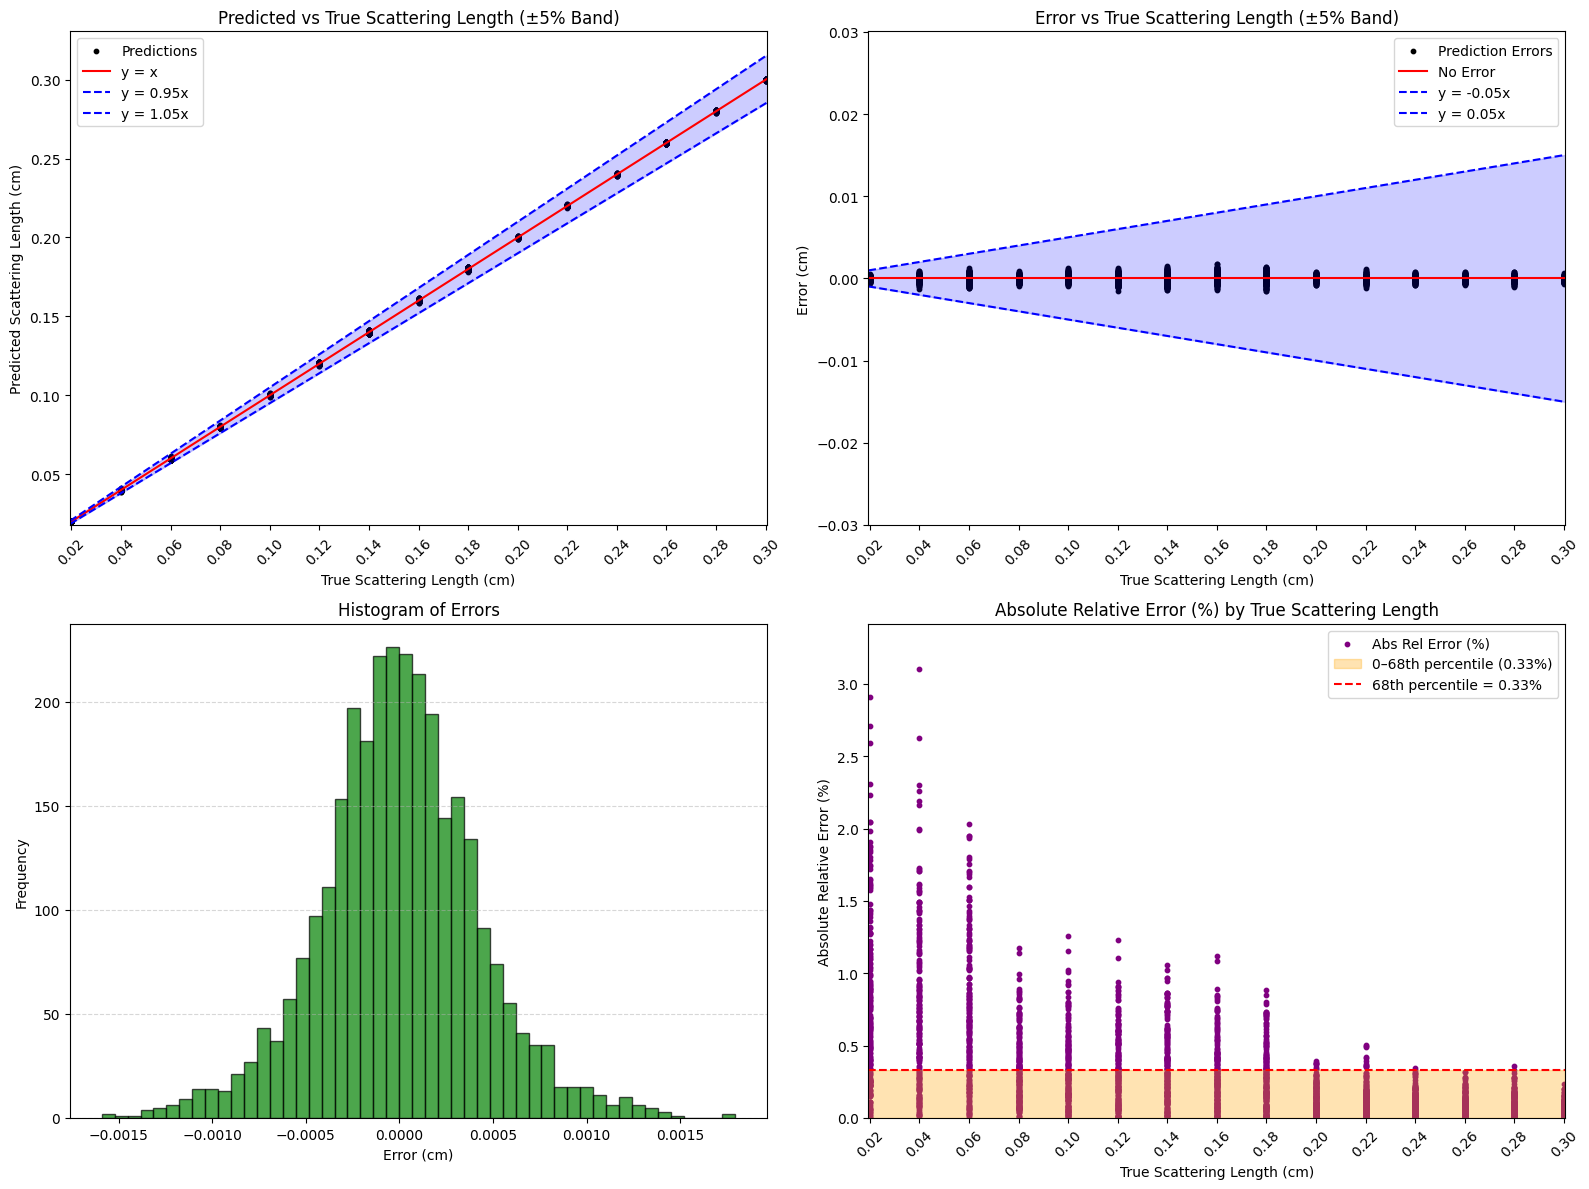

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Dataset 정의: 500×500 이미지를 PatchEmbedding 없이 그대로 사용
# ─────────────────────────────────────────────────────────────────────────────
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, lbl_min, lbl_max):
        """
        images: (N, 500, 500) numpy array, raw pixel values (0~4095)
        labels: (N,) numpy array, raw labels
        lbl_min, lbl_max: 레이블 Min–Max 정규화 상수
        """
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.lbl_min = lbl_min
        self.lbl_max = lbl_max
        self.to_tensor = T.ToTensor()  # (H, W) → (1, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]   # (500, 500)
        lbl = self.labels[idx]   # float

        # 1) [0,4095] → [0,1]
        img_norm = img / 4095.0

        # 2) Grayscale → Tensor (1, 500, 500)
        img_tensor = self.to_tensor(img_norm)

        # 3) 레이블 Min–Max 정규화 → [-1,1]
        lbl_norm = (lbl - self.lbl_min) / (self.lbl_max - self.lbl_min + 1e-8)  # [0,1]
        lbl_scaled = lbl_norm * 2.0 - 1.0                                       # [-1,1]
        lbl_tensor = torch.tensor(lbl_scaled, dtype=torch.float32)

        return img_tensor, lbl_tensor


# ─────────────────────────────────────────────────────────────────────────────
# 2) ViT 모델 정의: 패치 크기 50, 3 Transformer 블록
# ─────────────────────────────────────────────────────────────────────────────
class ViT50_3block(nn.Module):
    def __init__(self,
                 img_size=500,
                 patch_size=50,
                 embed_dim=256,
                 depth=3,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=1):
        """
        img_size: 입력 이미지 해상도 (여기서는 500×500)
        patch_size: 각 패치 크기 (50×50)
        embed_dim: 패치 임베딩 차원(여기선 256)
        depth: Transformer Encoder 레이어 개수 (3개)
        num_heads: 멀티헤드 어텐션 헤드 수 (8개)
        mlp_dim: Transformer 내부 MLP 숨겨진 차원 (512)
        num_classes: 출력 노드 수 (회귀용이므로 1)
        """
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size."
        num_patches = (img_size // patch_size) ** 2  # (500/50)² = 10×10 = 100

        # 2-1) Patch Embedding: Conv2d(1→embed_dim, kernel=patch_size, stride=patch_size)
        self.patch_embed = nn.Conv2d(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        # 결과: (B, embed_dim, 10, 10)

        # 2-2) Class Token 학습 파라미터
        #   (시퀀스 앞에 붙일 학습 가능한 토큰, shape=(1,1,embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # 2-3) Positional Embedding: (1, num_patches+1, embed_dim)
        #   시퀀스 길이 = 패치 수(100) + cls 토큰(1) = 101
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # 2-4) Transformer Encoder: 3개의 레이어 (nn.TransformerEncoderLayer 반복)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=0.0,
            activation='gelu',
            batch_first=False  # (seq_len, batch, embed_dim) 입력을 기대
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 2-5) 회귀용 Head: Transformer 마지막 CLS 출력(256차원) → Linear(256→1)
        self.head = nn.Linear(embed_dim, num_classes)

        # 2-6) 파라미터 초기화
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        x: (B, 1, 500, 500)
        """
        B = x.size(0)

        # (1) Patch Embedding
        #    입력 (B,1,500,500) → Conv2d → (B, embed_dim, 10, 10)
        x = self.patch_embed(x)

        # (2) Flatten & Transpose
        #    (B, embed_dim, 10, 10) → (B, embed_dim, 100) → (B, 100, embed_dim)
        x = x.flatten(2).transpose(1, 2)

        # (3) CLS 토큰 결합
        #    cls_token (1,1,embed_dim) → expand → (B,1,embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        #    (B,1,embed_dim) + (B,100,embed_dim) → (B,101,embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)

        # (4) Positional Embedding 추가
        #    pos_embed (1,101,embed_dim) → 브로드캐스트 → (B,101,embed_dim)
        x = x + self.pos_embed

        # (5) Transformer 인코더 expects (seq_len, batch, embed_dim)
        x = x.transpose(0, 1)  # (101, B, embed_dim)
        x = self.transformer(x)  # (101, B, embed_dim)

        # (6) CLS 토큰 출력만 사용: x[0] → (B, embed_dim)
        cls_out = x[0]

        # (7) 회귀 Head: (B, embed_dim) → (B, 1) → squeeze → (B,)
        out = self.head(cls_out).squeeze(-1)
        return out


# ─────────────────────────────────────────────────────────────────────────────
# 3) train_validate 함수: Early Stopping + ReduceLROnPlateau + AdamW
# ─────────────────────────────────────────────────────────────────────────────
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler,
                   num_epochs=100, patience=10, save_path='./best_vit50_3block.pth'):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, num_epochs + 1):
        # ─── Training ─────────────────────────────────────────────────────
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)

            optimizer.zero_grad()
            outputs = model(images)      # (B,)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        # ─── Validation ───────────────────────────────────────────────────
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        val_loss   = running_val_loss   / len(val_loader.dataset)
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {lr:.6g}")

        # ─── ReduceLROnPlateau 스케줄러 업데이트 ─────────────────────────────
        #    scheduler.step(val_loss) → val_loss 기반으로 LR 감소
        scheduler.step(val_loss)

        # ─── Early Stopping 및 Best Model 저장 ─────────────────────────────
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), save_path)
            print(f"  → New best val loss: {best_val_loss:.6f}, saved to {save_path}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return model


# ─────────────────────────────────────────────────────────────────────────────
# 4) 전체 파이프라인: 데이터 로드 → DataLoader → 모델 정의 → 학습 → 평가 → 시각화
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    # (A) HDF5 로드
    hdf5_path = '/home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_np_10_all.h5'
    with h5py.File(hdf5_path, 'r') as f:
        raw_images = f['images'][:]   # (N, 500, 500)
        raw_labels = f['labels'][:]   # (N,)

    print(f"Total samples: {raw_images.shape[0]}")

    # 레이블 Min/Max 계산
    lbl_min = raw_labels.min()
    lbl_max = raw_labels.max()

    # (B) Dataset & DataLoader 생성 (60/20/20 split)
    dataset = NoisyImageDataset(raw_images, raw_labels, lbl_min, lbl_max)
    unique_labels = np.unique(raw_labels)

    train_indices, val_indices, test_indices = [], [], []
    for lbl in unique_labels:
        inds = np.where(raw_labels == lbl)[0].tolist()
        random.shuffle(inds)
        n = len(inds)
        n_test = int(n * 0.20)
        n_val  = int(n * 0.10)
        test_indices.extend(inds[:n_test])
        val_indices.extend(inds[n_test:n_test + n_val])
        train_indices.extend(inds[n_test + n_val:])

    batch_size = 32
    train_loader = DataLoader(Subset(dataset, train_indices),
                              batch_size=batch_size, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader   = DataLoader(Subset(dataset, val_indices),
                              batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)
    test_loader  = DataLoader(Subset(dataset, test_indices),
                              batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)

    print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

    # (C) 모델 정의: ViT50_3block
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ViT50_3block(
        img_size=500,
        patch_size=50,
        embed_dim=128,
        depth=3,
        num_heads=8,
        mlp_dim=512,
        num_classes=1
    ).to(device)

    # (D) Optimizer & Scheduler: AdamW + ReduceLROnPlateau
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.5,
                                  patience=3,
                                  verbose=True)

    # (E) 모델 학습
    best_model_path = './best_vit50_3block_hole_last.pth'
    model = train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        num_epochs=150,
        patience=10,
        save_path=best_model_path
    )

    # (F) 테스트 세트 평가
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)
            outputs = model(images)      # (B,)

            # 정규화 복원 → 원래 스케일로
            labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
            preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

            true_vals.extend(labels_orig.tolist())
            pred_vals.extend(preds_orig.tolist())

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    errors = pred_vals - true_vals
    abs_rel_errors = np.abs(errors / true_vals) * 100.0

    # (G) 결과 시각화
    plt.figure(figsize=(16, 12))
    mn = min(true_vals.min(), pred_vals.min())
    mx = max(true_vals.max(), pred_vals.max())
    unique_true_labels = np.unique(true_vals)

    # 1) Predicted vs True with ±5% Band
    ax1 = plt.subplot(2, 2, 1)
    ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
    ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
    ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
    ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
    ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
    ax1.set_xticks(unique_true_labels)
    ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
    ax1.set_xlabel("True Scattering Length (cm)")
    ax1.set_ylabel("Predicted Scattering Length (cm)")
    ax1.set_xlim(mn, mx)
    ax1.set_ylim(mn * 0.9, mx * 1.1)
    ax1.legend()

    # 2) Error vs True with ±5% Band
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
    ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
    ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
    ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
    ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
    ax2.set_xticks(unique_true_labels)
    ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax2.set_title("Error vs True Scattering Length (±5% Band)")
    ax2.set_xlabel("True Scattering Length (cm)")
    ax2.set_ylabel("Error (cm)")
    ax2.set_xlim(mn, mx)
    ax2.set_ylim(-0.1 * mx, 0.1 * mx)
    ax2.legend()

    # 3) Histogram of Errors (50 bins)
    ax3 = plt.subplot(2, 2, 3)
    bins = np.linspace(errors.min(), errors.max(), 50)
    ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
    ax3.set_title("Histogram of Errors")
    ax3.set_xlabel("Error (cm)")
    ax3.set_ylabel("Frequency")
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    # 4) Absolute Relative Error (%) by True with 68th Percentile
    ax4 = plt.subplot(2, 2, 4)
    ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
    perc68 = np.percentile(abs_rel_errors, 68)
    ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                     label=f'0–68th percentile ({perc68:.2f}%)')
    ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
               label=f'68th percentile = {perc68:.2f}%')
    ax4.set_xticks(unique_true_labels)
    ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
    ax4.set_xlabel("True Scattering Length (cm)")
    ax4.set_ylabel("Absolute Relative Error (%)")
    ax4.set_xlim(mn, mx)
    ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
    ax4.legend()

    plt.tight_layout()
    plt.show()

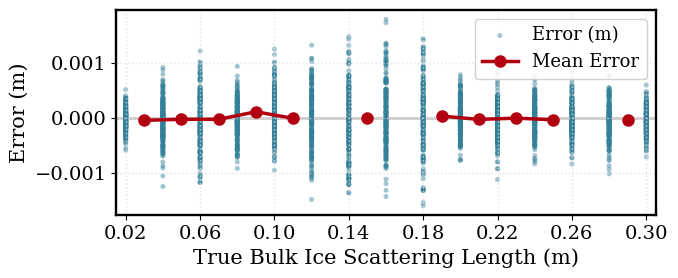

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# (가정) true_vals, pred_vals, errors, abs_rel_errors 준비되어 있음

bins = np.arange(0.02, 0.32, 0.02)
bin_centers = (bins[:-1] + bins[1:]) / 2

bias_means = []
for i in range(len(bins) - 1):
    mask = (true_vals >= bins[i]) & (true_vals < bins[i+1])
    if np.any(mask):
        bias = np.mean(errors[mask])
    else:
        bias = np.nan
    bias_means.append(bias)
bias_means = np.array(bias_means)

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})
fig, ax = plt.subplots(figsize=(7, 3))
dot_color = '#338099'
line_color = '#B20010'

ax.scatter(true_vals, errors, color=dot_color, s=13, alpha=0.45, edgecolors='none', label='Error (m)')
ax.plot(bin_centers, bias_means, color=line_color, lw=2.5, marker='o', markersize=8, label='Mean Error')

ax.set_xlim(0.015, 0.305)
ax.set_xticks(np.arange(0.02, 0.32, 0.04))
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Error (m)")
ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.legend(fontsize=13, loc='upper right', frameon=True, fancybox=True, framealpha=0.90)
plt.tight_layout()
plt.show()


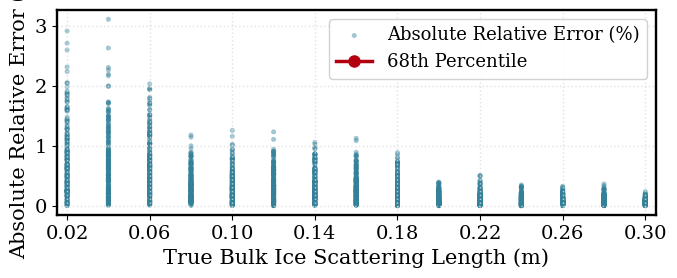

In [6]:
percentiles_68 = []
unique_labels = np.arange(0.02, 0.32, 0.02)
for val in unique_labels:
    mask = (true_vals == val)
    if np.any(mask):
        p68 = np.percentile(abs_rel_errors[mask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

fig, ax = plt.subplots(figsize=(7, 3))
sc = ax.scatter(true_vals, abs_rel_errors, color='#338099', s=13, alpha=0.45, edgecolors='none', label='Absolute Relative Error (%)')
ln, = ax.plot(unique_labels, percentiles_68, color='#B20010', lw=2.5, marker='o', markersize=8, label='68th Percentile')

ax.set_xlim(0.015, 0.305)
ax.set_xticks(np.arange(0.02, 0.32, 0.04))
ax.set_xlabel("True Bulk Ice Scattering Length (m)")
ax.set_ylabel("Absolute Relative Error (%)")
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
ax.legend(fontsize=13, loc='upper right', frameon=True, fancybox=True, framealpha=0.90)
plt.tight_layout()
plt.show()


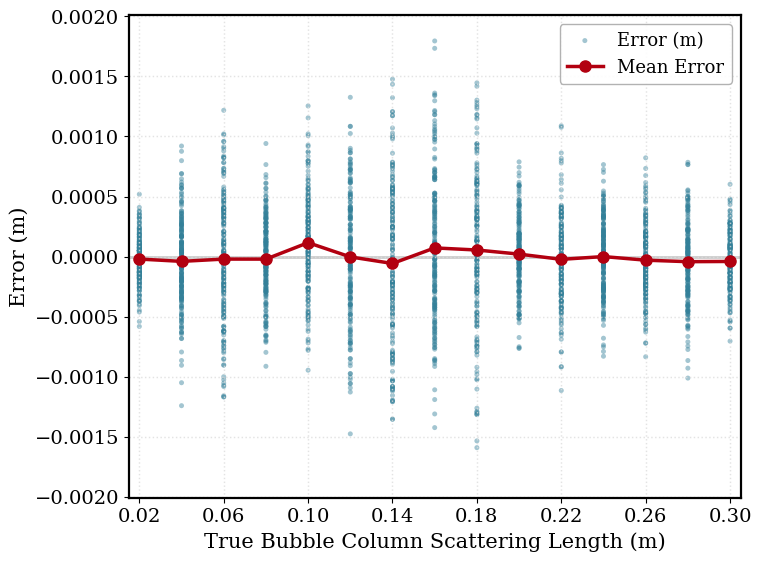

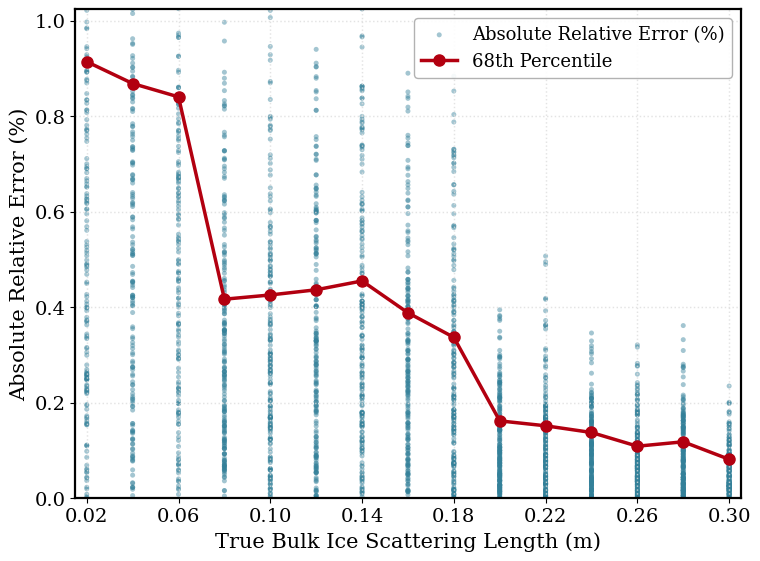

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# (가정) 아래 변수들이 이미 계산되어 있다고 가정합니다:
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m) [0.02~0.30 범위]
#    pred_vals       : numpy array of shape (N,), 예측된 Scattering Length (m)
#    errors          : pred_vals - true_vals (m)
#    abs_rel_errors  : np.abs(errors / true_vals) * 100.0  (%)
# ─────────────────────────────────────────────────────────────────────────────

# x축 레이블 간격: 0.02 ~ 0.30, 0.02 단위
x_ticks = np.arange(0.02, 0.32, 0.02)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Bias (Mean Error) 계산: 각 x_tick 구간(예: 0.02, 0.04 등)마다 평균 오차
# ─────────────────────────────────────────────────────────────────────────────
bias_means = []
for xt in x_ticks:
    # true_vals == xt 인 샘플 선택 (부동소수점 오차를 막기 위해 np.isclose 사용)
    mask = np.isclose(true_vals, xt, atol=1e-6)
    if np.any(mask):
        bias_means.append(np.mean(errors[mask]))
    else:
        bias_means.append(np.nan)
bias_means = np.array(bias_means)

# ─────────────────────────────────────────────────────────────────────────────
# 2) 첫 번째 그림: Bias (Mean Error) vs True Scattering Length
# ─────────────────────────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'    # scatter 점 색
line_color = '#B20010'   # 평균선 색

# (A) 모든 샘플의 Error 점 찍기
ax.scatter(
    true_vals, errors,
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Error (m)'
)

# (B) x_ticks 위치에서 평균 오차 연결 (점+선)
ax.plot(
    x_ticks, bias_means,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='Mean Error'
)

# (C) 축 레이블 및 범위 설정
ax.set_xlim(0.015, 0.305)
ax.set_xticks(x_ticks[::2])  # 0.02, 0.06, 0.10, ... 0.30 처럼 0.04 간격 눈금
ax.set_xlabel("True Bubble Column Scattering Length (m)", fontsize=15)
ax.set_ylabel("Error (m)", fontsize=15)

# (D) y=0 선 강조
ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)

# (E) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (F) y축 범위 약간 패딩
y_max = np.nanmax([np.abs(errors).max(), np.abs(bias_means).max()])
y_pad = 0.12 * y_max
ax.set_ylim(-y_max - y_pad, y_max + y_pad)

# (G) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (H) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 3) Absolute Relative Error (%) 68th Percentile 계산
# ─────────────────────────────────────────────────────────────────────────────
p68_vals = []
for xt in x_ticks:
    mask = np.isclose(true_vals, xt, atol=1e-6)
    if np.any(mask):
        p68_vals.append(np.percentile(abs_rel_errors[mask], 68))
    else:
        p68_vals.append(np.nan)
p68_vals = np.array(p68_vals)

# ─────────────────────────────────────────────────────────────────────────────
# 4) 두 번째 그림: Absolute Relative Error (%) vs True Scattering Length
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'
line_color = '#B20010'

# (A) 모든 샘플의 절대 상대오차 scatter
ax.scatter(
    true_vals, abs_rel_errors,
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Absolute Relative Error (%)'
)

# (B) x_ticks 위치에서 68th percentile 연결 (점+선)
ax.plot(
    x_ticks, p68_vals,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='68th Percentile'
)

# (C) 축 레이블 및 범위 설정
ax.set_xlim(0.015, 0.305)
ax.set_xticks(x_ticks[::2])  # 0.02, 0.06, 0.10, ... 0.30
ax.set_xlabel("True Bulk Ice Scattering Length (m)", fontsize=15)
ax.set_ylabel("Absolute Relative Error (%)", fontsize=15)

# (D) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (E) y축 범위 약간 패딩
y_max_rel = np.nanmax(p68_vals[~np.isnan(p68_vals)])
y_pad_rel = 0.12 * y_max_rel
ax.set_ylim(0, y_max_rel + y_pad_rel)

# (F) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (G) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


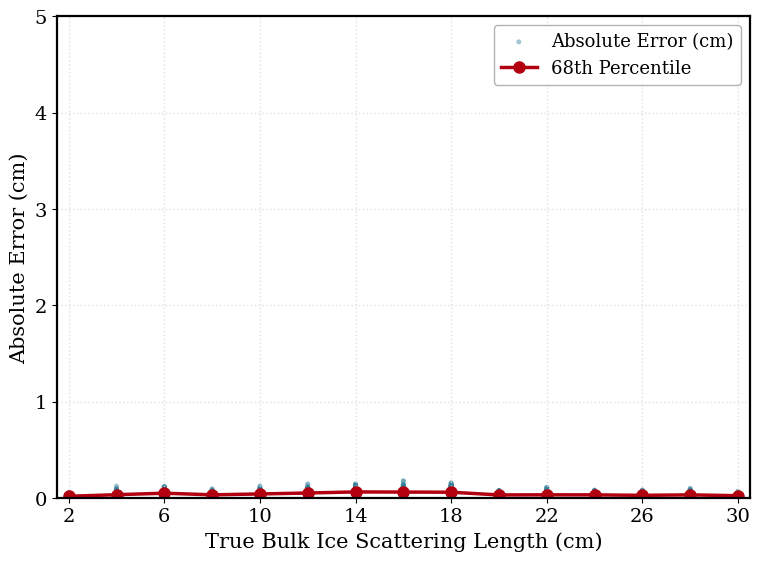

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# (가정) 아래 변수들이 이미 계산되어 있다고 가정합니다:
#    true_vals       : numpy array of shape (N,), 실제 scattering length (m) [0.02~0.30 m]
#    pred_vals       : numpy array of shape (N,), 예측된 scattering length (m)
#    errors          : pred_vals - true_vals (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# ● “cm 단위로 변환” (미터→센티미터, x100)
true_cm   = true_vals * 100.0       # [단위: cm]
errors_cm = errors * 100.0          # [단위: cm]

# 0.02 m → 2 cm, 0.30 m → 30 cm 까지 0.02 m 간격 = 2 cm 간격
x_ticks_cm = np.arange(2, 32, 2)    # [2, 4, 6, …, 30] (단위: cm)

# 68th percentile 계산도 “cm 단위로 에러”에서 동일하게 진행
p68_vals_cm = []
for xt_cm in x_ticks_cm:
    # true_cm == xt_cm 인 샘플 선택
    mask = np.isclose(true_cm, xt_cm, atol=1e-3)
    if np.any(mask):
        # 절대 오차(errors_cm)에서 68th percentile
        p68_vals_cm.append(np.percentile(np.abs(errors_cm[mask]), 68))
    else:
        p68_vals_cm.append(np.nan)
p68_vals_cm = np.array(p68_vals_cm)

# ─────────────────────────────────────────────────────────────────────────────
# “Absolute Error (cm)” vs “True Scattering Length (cm)” 그림
# ─────────────────────────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'
line_color = '#B20010'

# (A) 모든 샘플의 “절대 오차 (cm)”를 scatter
ax.scatter(
    true_cm, np.abs(errors_cm),
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Absolute Error (cm)'
)

# (B) x_ticks_cm 위치에서 68th percentile 연결 (점+선)
ax.plot(
    x_ticks_cm, p68_vals_cm,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='68th Percentile'
)

# (C) 축 레이블 및 범위 설정 (cm 단위)
ax.set_xlim(1.5, 30.5)
ax.set_xticks(x_ticks_cm[::2])  # 2, 6, 10, …, 30 (간격 4cm)
ax.set_xlabel("True Bulk Ice Scattering Length (cm)", fontsize=15)
ax.set_ylabel("Absolute Error (cm)", fontsize=15)

# (D) y축 상한을 예를 들어 5 cm 로 고정 (원한다면)
ax.set_ylim(0, 5.0)

# (E) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (F) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (G) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


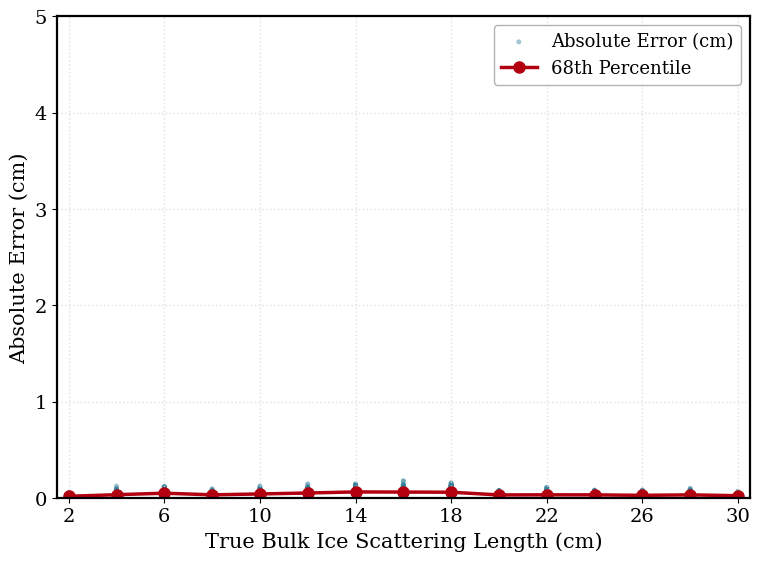

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# (가정) 아래 변수들이 이미 계산되어 있다고 가정합니다:
#    true_vals       : numpy array of shape (N,), 실제 scattering length (m) [0.02~0.30 m]
#    pred_vals       : numpy array of shape (N,), 예측된 scattering length (m)
#    errors          : pred_vals - true_vals (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# ● “cm 단위로 변환” (미터→센티미터, x100)
true_cm   = true_vals * 100.0       # [단위: cm]
errors_cm = errors * 100.0          # [단위: cm]

# 0.02 m → 2 cm, 0.30 m → 30 cm 까지 0.02 m 간격 = 2 cm 간격
x_ticks_cm = np.arange(2, 32, 2)    # [2, 4, 6, …, 30] (단위: cm)

# 68th percentile 계산도 “cm 단위로 에러”에서 동일하게 진행
p68_vals_cm = []
for xt_cm in x_ticks_cm:
    # true_cm == xt_cm 인 샘플 선택
    mask = np.isclose(true_cm, xt_cm, atol=1e-3)
    if np.any(mask):
        # 절대 오차(errors_cm)에서 68th percentile
        p68_vals_cm.append(np.percentile(np.abs(errors_cm[mask]), 68))
    else:
        p68_vals_cm.append(np.nan)
p68_vals_cm = np.array(p68_vals_cm)

# ─────────────────────────────────────────────────────────────────────────────
# “Absolute Error (cm)” vs “True Scattering Length (cm)” 그림
# ─────────────────────────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'
line_color = '#B20010'

# (A) 모든 샘플의 “절대 오차 (cm)”를 scatter
ax.scatter(
    true_cm, np.abs(errors_cm),
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Absolute Error (cm)'
)

# (B) x_ticks_cm 위치에서 68th percentile 연결 (점+선)
ax.plot(
    x_ticks_cm, p68_vals_cm,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='68th Percentile'
)

# (C) 축 레이블 및 범위 설정 (cm 단위)
ax.set_xlim(1.5, 30.5)
ax.set_xticks(x_ticks_cm[::2])  # 2, 6, 10, …, 30 (간격 4cm)
ax.set_xlabel("True Bulk Ice Scattering Length (cm)", fontsize=15)
ax.set_ylabel("Absolute Error (cm)", fontsize=15)

# (D) y축 상한을 예를 들어 5 cm 로 고정 (원한다면)
ax.set_ylim(0, 5.0)

# (E) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (F) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (G) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()

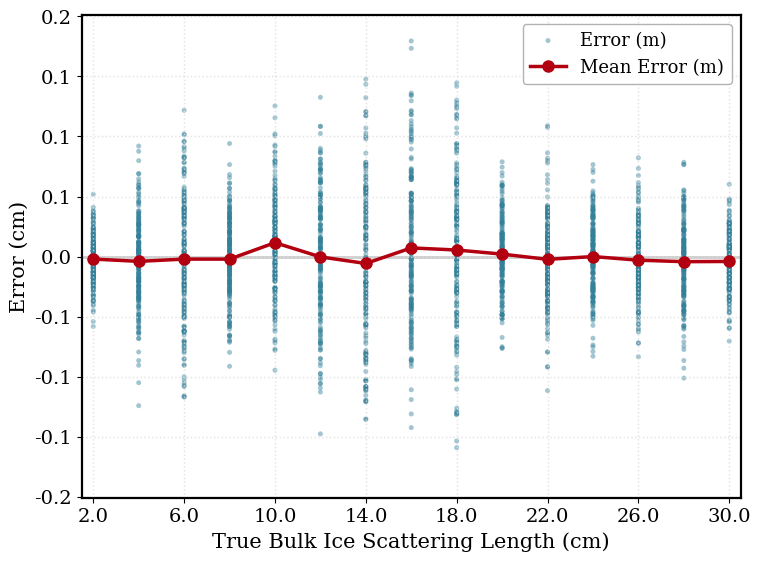

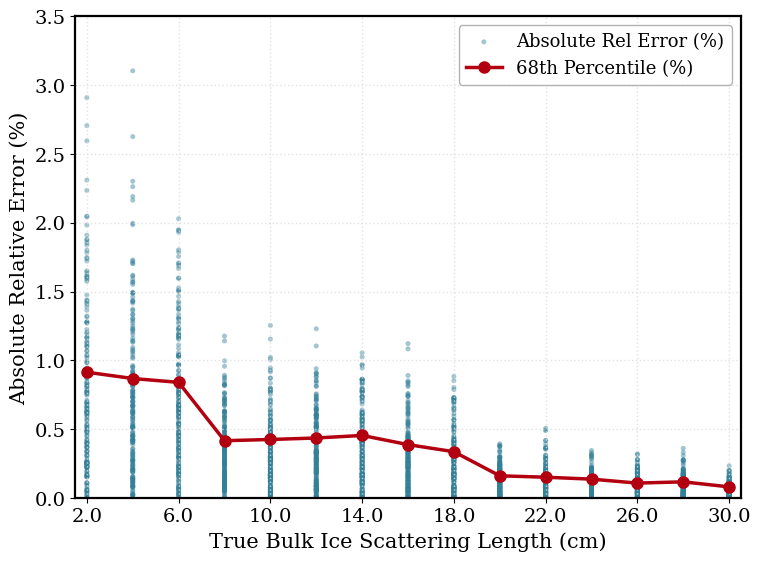

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ─────────────────────────────────────────────────────────────────────────────
# (가정) 아래 변수들이 이미 계산되어 있다고 가정합니다:
#    true_vals       : numpy array of shape (N,), 실제 Scattering Length (m) [0.02~0.30 m]
#    pred_vals       : numpy array of shape (N,), 예측된 Scattering Length (m)
#    errors          : pred_vals - true_vals (m)
#    abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# x축 레이블 간격: 0.02 ~ 0.30, 0.02 단위 (m 단위 눈금 위치)
x_ticks = np.arange(0.02, 0.32, 0.02)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Bias(Mean Error) vs True (m 단위 데이터) ─ 밑에 formatter 로 “+100” 해서 cm로 표시
# ─────────────────────────────────────────────────────────────────────────────
# Bias(Mean error) 계산
bias_means = []
for xt in x_ticks:
    mask = np.isclose(true_vals, xt, atol=1e-6)
    if np.any(mask):
        bias_means.append(np.mean(errors[mask]))
    else:
        bias_means.append(np.nan)
bias_means = np.array(bias_means)

# ▲ Formatter 정의: 눈금값(x 또는 y)을 받아서 “x*100”을 리턴 (cm로 바꾸기)
def to_cm(x, pos):
    return f"{100*x:.1f}"  # 소수점 한 자리까지 표시. ex) 0.02 → "2.0"

plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'
line_color = '#B20010'

# (A) Scatter: 실제 미터 단위 데이터
ax.scatter(
    true_vals, errors,
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Error (m)'
)

# (B) x_ticks 위치에서 평균 에러 연결
ax.plot(
    x_ticks, bias_means,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='Mean Error (m)'
)

# (C) 축, 눈금 설정 (데이터 범위는 m 그대로, label만 cm로 표시)
ax.set_xlim(0.015, 0.305)
ax.set_xticks(x_ticks[::2])  # 0.02, 0.06, 0.10, …, 0.30 (m 단위 위치)
ax.set_xlabel("True Bulk Ice Scattering Length (cm)", fontsize=15)
ax.set_ylabel("Error (cm)", fontsize=15)

# (D) y=0 선 강조
ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)

# (E) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (F) y축 범위 약간 패딩
y_max = np.nanmax([np.abs(errors).max(), np.abs(bias_means).max()])
y_pad = 0.12 * y_max
ax.set_ylim(-y_max - y_pad, y_max + y_pad)

# (G) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (H) Formatter 적용: x축, y축 눈금을 100× 표시
ax.xaxis.set_major_formatter(FuncFormatter(to_cm))
ax.yaxis.set_major_formatter(FuncFormatter(to_cm))

# (I) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 2) Absolute Relative Error (%) vs True (m 단위 데이터, y축은 그대로 %)
#    단, x축 눈금은 cm(100×)로 표시만 변경
# ─────────────────────────────────────────────────────────────────────────────
# 68th percentile 계산
p68_vals = []
for xt in x_ticks:
    mask = np.isclose(true_vals, xt, atol=1e-6)
    if np.any(mask):
        p68_vals.append(np.percentile(abs_rel_errors[mask], 68))
    else:
        p68_vals.append(np.nan)
p68_vals = np.array(p68_vals)

fig, ax = plt.subplots(figsize=(8, 6))

# (A) Scatter: 실제 절대 상대오차 (remain %)
ax.scatter(
    true_vals, abs_rel_errors,
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Absolute Rel Error (%)'
)

# (B) x_ticks 위치에서 68th percentile 연결
ax.plot(
    x_ticks, p68_vals,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='68th Percentile (%)'
)

# (C) 축, 눈금 설정 (x축 cm 단위 표시, y축은 % 그대로)
ax.set_xlim(0.015, 0.305)
ax.set_xticks(x_ticks[::2])  # 0.02, 0.06, 0.10, …, 0.30 (m 위치)
ax.set_xlabel("True Bulk Ice Scattering Length (cm)", fontsize=15)
ax.set_ylabel("Absolute Relative Error (%)", fontsize=15)

# (D) y축 상한 고정 (0~5%)
ax.set_ylim(0, 3.5)

# (E) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (F) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (G) Formatter: x축 눈금을 cm 단위로 표시
ax.xaxis.set_major_formatter(FuncFormatter(to_cm))
# y축은 이미 %이므로 Formatter 변경 불필요

# (H) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


In [13]:
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 가정: abs_rel_errors 라는 numpy array가 이미 준비되어 있습니다.
#      (shape = (N,), 각 샘플의 Absolute Relative Error (%))
# ─────────────────────────────────────────────────────────────────────────────

# Mean Absolute Relative Error
mean_abs_rel_error = np.mean(abs_rel_errors)

# Overall 68th Percentile
overall_p68 = np.percentile(abs_rel_errors, 68)

print(f"Mean Absolute Relative Error: {mean_abs_rel_error:.3f}%")
print(f"Overall 68th Percentile: {overall_p68:.3f}%")


Mean Absolute Relative Error: 0.318%
Overall 68th Percentile: 0.331%


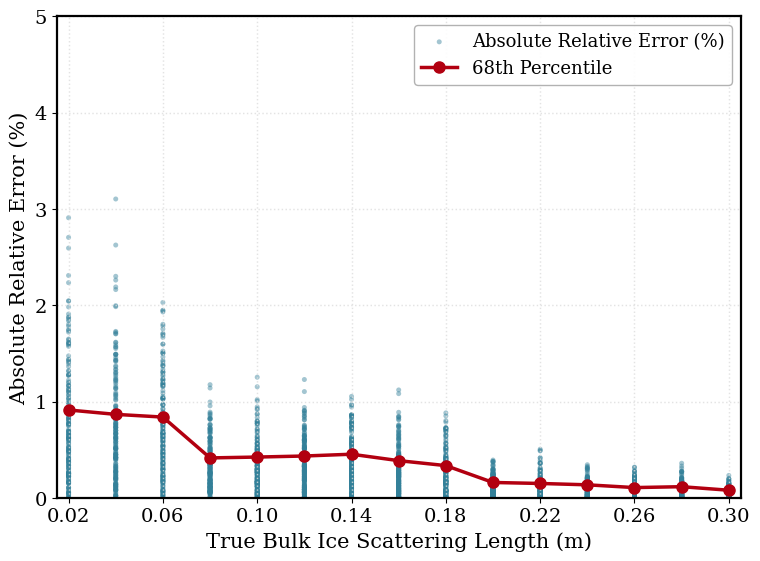

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# (가정) true_vals, abs_rel_errors 계산이 이미 되어 있다고 가정합니다.
#     true_vals       : numpy array of shape (N,), 실제 Scattering Length (m) [0.02~0.30]
#     abs_rel_errors  : numpy array of shape (N,), Absolute Relative Error (%) 
# ─────────────────────────────────────────────────────────────────────────────

# x축 레이블 간격: 0.02 ~ 0.30, 0.02 단위
x_ticks = np.arange(0.02, 0.32, 0.02)

# ─────────────────────────────────────────────────────────────────────────────
# 68th Percentile 계산: 각 x_tick 위치마다
# ─────────────────────────────────────────────────────────────────────────────
p68_vals = []
for xt in x_ticks:
    mask = np.isclose(true_vals, xt, atol=1e-6)
    if np.any(mask):
        p68_vals.append(np.percentile(abs_rel_errors[mask], 68))
    else:
        p68_vals.append(np.nan)
p68_vals = np.array(p68_vals)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Absolute Relative Error (%) vs True Scattering Length (y축 최대 5%)
# ─────────────────────────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.7,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=(8, 6))
dot_color = '#338099'
line_color = '#B20010'

# (A) 모든 샘플의 절대 상대오차 scatter
ax.scatter(
    true_vals, abs_rel_errors,
    color=dot_color, s=13, alpha=0.45, edgecolors='none', rasterized=True,
    label='Absolute Relative Error (%)'
)

# (B) x_ticks 위치에서 68th percentile 연결 (점+선)
ax.plot(
    x_ticks, p68_vals,
    color=line_color, lw=2.5, marker='o', markersize=8,
    label='68th Percentile'
)

# (C) 축 레이블 및 범위 설정
ax.set_xlim(0.015, 0.305)
ax.set_xticks(x_ticks[::2])  # 0.02, 0.06, 0.10, …, 0.30
ax.set_xlabel("True Bulk Ice Scattering Length (m)", fontsize=15)
ax.set_ylabel("Absolute Relative Error (%)", fontsize=15)

# (D) y축을 0~5%로 고정
ax.set_ylim(0, 5.0)

# (E) 그리드
ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)

# (F) 외곽 선 두께
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# (G) 범례
legend = ax.legend(
    fontsize=13, loc='upper right',
    frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA'
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout(pad=1.5)
plt.show()


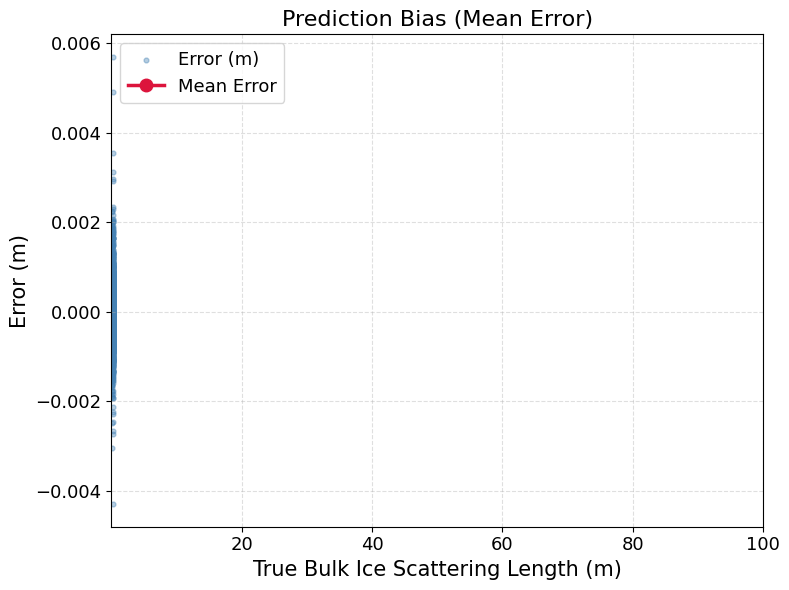

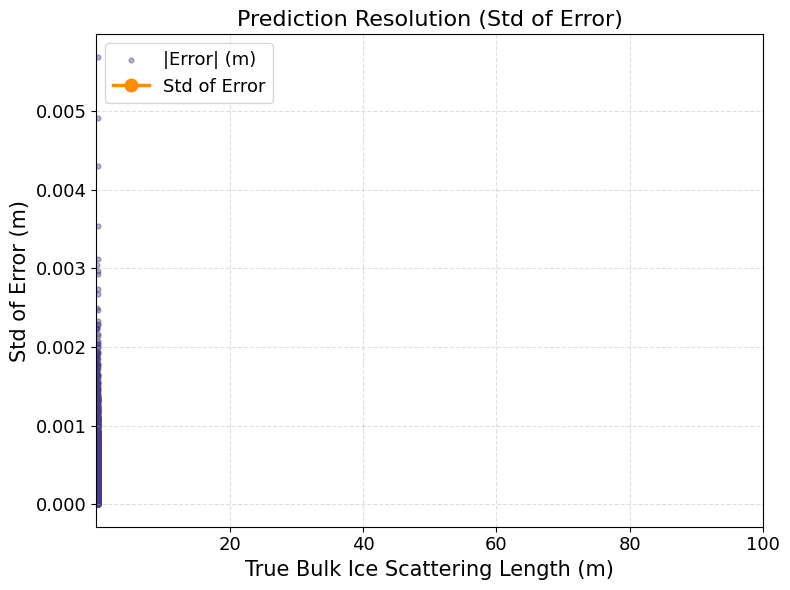

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# (1) 기존 코드로 true_vals, pred_vals, errors, abs_rel_errors 계산

# (5) Bias(Mean Error) & Resolution(STD of Error) 구간별 계산
bins = np.arange(20, 101, 20)  # [20, 40, 60, 80, 100]
bin_centers = (bins[:-1] + bins[1:]) / 2

bias_means = []
resol_stds = []
for i in range(len(bins)-1):
    mask = (true_vals >= bins[i]) & (true_vals < bins[i+1])
    if np.sum(mask) > 0:
        bias = np.mean(errors[mask])
        resol = np.std(errors[mask])
    else:
        bias = np.nan
        resol = np.nan
    bias_means.append(bias)
    resol_stds.append(resol)
bias_means = np.array(bias_means)
resol_stds = np.array(resol_stds)

# (6) Bias plot (Mean error by true)
plt.figure(figsize=(8, 6))
plt.scatter(true_vals, errors, color='steelblue', s=12, alpha=0.4, label='Error (m)')
plt.plot(bin_centers, bias_means, color='crimson', lw=2.5, marker='o', markersize=9, label='Mean Error')
for xc, bm in zip(bin_centers, bias_means):
    if not np.isnan(bm):
        plt.text(xc, bm + 0.05, f"{bm:.3f}", fontsize=13,
                 ha='center', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.88))
plt.xlabel("True Bulk Ice Scattering Length (m)", fontsize=15)
plt.ylabel("Error (m)", fontsize=15)
plt.xticks(bins, fontsize=13)
plt.yticks(fontsize=13)
plt.title("Prediction Bias (Mean Error)", fontsize=16)
plt.legend(fontsize=13, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# (7) Resolution plot (Std error by true)
plt.figure(figsize=(8, 6))
plt.scatter(true_vals, np.abs(errors), color='darkslateblue', s=12, alpha=0.4, label='|Error| (m)')
plt.plot(bin_centers, resol_stds, color='darkorange', lw=2.5, marker='o', markersize=9, label='Std of Error')
for xc, rs in zip(bin_centers, resol_stds):
    if not np.isnan(rs):
        plt.text(xc, rs + 0.05, f"{rs:.3f}", fontsize=13,
                 ha='center', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.16', facecolor='white', edgecolor='black', lw=1, alpha=0.88))
plt.xlabel("True Bulk Ice Scattering Length (m)", fontsize=15)
plt.ylabel("Std of Error (m)", fontsize=15)
plt.xticks(bins, fontsize=13)
plt.yticks(fontsize=13)
plt.title("Prediction Resolution (Std of Error)", fontsize=16)
plt.legend(fontsize=13, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 가정: 아래 두 변수는 이미 계산되어 있습니다.
#
#    true_vals       # numpy array of shape (N,), 실제 Scattering Length (m) 값
#    abs_rel_errors  # numpy array of shape (N,), Absolute Relative Error (%) 값
# ─────────────────────────────────────────────────────────────────────────────

# 0) 0% 오차를 살짝 위로 띄우기 위한 작은 오프셋 ε 정의
epsilon = 1e-3  # 0.001% 만큼 살짝 위로 띄워줍니다.

# copy해서 0값에만 ε를 더해줍니다(원본 데이터는 그대로 둠)
abs_rel_plot = abs_rel_errors.copy()
abs_rel_plot[abs_rel_plot == 0] = epsilon

# 1) 20 m ~ 100 m 구간에 속하는 데이터만 선택 (필요시)
mask_range = (true_vals >= 20) & (true_vals <= 100)
true_in_range = true_vals[mask_range]
errs_in_range = abs_rel_plot[mask_range]

# 2) 고유한 True Scattering Length(범위 내) 구해서 정렬
unique_vals = np.unique(true_in_range)
# (만약 데이터가 정수 단위가 아니고, 특정 값만 있을 경우 그대로 사용)

# 3) 각 고유 값마다 68th percentile 계산
percentiles_68 = []
for val in unique_vals:
    submask = (true_in_range == val)
    if np.sum(submask) > 0:
        p68 = np.percentile(errs_in_range[submask], 68)
    else:
        p68 = np.nan
    percentiles_68.append(p68)
percentiles_68 = np.array(percentiles_68)

# 4) 전체 평균 및 전체 68th percentile (참고용)
avg_abs_rel_error = np.mean(abs_rel_errors[(true_vals >= 20) & (true_vals <= 100)])
overall_p68      = np.percentile(abs_rel_errors[(true_vals >= 20) & (true_vals <= 100)], 68)

# ─────────────────────────────────────────────────────────────────────────────
# 5) 그림 그리기
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))

# (A) Scatter: 모든 샘플 (20~100 m 범위) 그리기
plt.scatter(
    true_in_range,                      # x: True Scattering Length (20~100)
    errs_in_range,                      # y: 오프셋 적용된 Absolute Rel Error (%)
    color='teal', 
    s=15,                               # 점 크기
    alpha=0.6, 
    label='Abs Rel Error (%)'
)

# (B) 68th percentile 선 그리기
plt.plot(
    unique_vals, 
    percentiles_68, 
    color='crimson', 
    linewidth=2, 
    marker='o', 
    markersize=6, 
    label='68th Percentile'
)

# (C) x축 눈금: 20, 30, 40, …, 100
xticks = np.arange(20, 101, 10)
plt.xticks(xticks, rotation=45)

# (D) y축 레이블과 제목, 범례
plt.xlabel("True Scattering Length (m)", fontsize=14)
plt.ylabel("Absolute Relative Error (%)", fontsize=14)
plt.title("Absolute Relative Error (%) vs True Scattering Length (20–100 m)", fontsize=16)

# (E) 0% 에 오프셋을 준 점이 명확히 보이도록 y축 아래 여유를 약간 줌
y_min = 0  # 절대 최소값을 0으로 두고
y_max = np.nanmax(abs_rel_errors[(true_vals >= 20) & (true_vals <= 100)]) * 1.1
plt.ylim(0, y_max)

# (F) 전체 평균 및 전체 68th percentile 표시
mid_x = (20 + 100) / 2
plt.text(
    mid_x, 
    y_max * 0.9, 
    f"Average Abs Rel Err: {avg_abs_rel_error:.3f}%\n"
    f"Overall 68th Percentile: {overall_p68:.3f}%", 
    fontsize=11, 
    ha='center', 
    va='top', 
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

# (G) 보조격자 추가
plt.grid(True, linestyle='--', alpha=0.4)

plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: cannot do a non-empty take from an empty axes.

In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) 이전에 정의한 ViT50_3block 모델, optimizer, scheduler와 동일하게 설정
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (A) 모델 정의
model = ViT50_3block(
    img_size=500,
    patch_size=50,
    embed_dim=128,   # 학습 시 사용한 값과 동일하게
    depth=3,
    num_heads=8,
    mlp_dim=512,
    num_classes=1
).to(device)

# (B) Optimizer + Scheduler
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=4,
    verbose=True
)

criterion = nn.MSELoss()

# ─────────────────────────────────────────────────────────────────────────────
# 2) 체크포인트 로드
#    (train_validate 함수에서 저장한 best 모델 파일을 지정)
# ─────────────────────────────────────────────────────────────────────────────
best_model_path = './best_vit50_3block.pth'
checkpoint = torch.load(best_model_path, map_location=device)

# 체크포인트가 딕셔너리 형태인지(state dict만인지) 확인
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    # {'model_state_dict': ..., 'optimizer_state_dict': ..., 'val_loss': ..., ...} 형태
    model.load_state_dict(checkpoint['model_state_dict'])
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 0)}. Continuing from epoch {start_epoch}.")
else:
    # 단순히 model.state_dict()만 저장된 경우
    model.load_state_dict(checkpoint)
    start_epoch = 1
    best_val_loss = float('inf')
    print("Loaded state_dict-only checkpoint. Starting from epoch 1.")

# ─────────────────────────────────────────────────────────────────────────────
# 3) 학습을 이어갈 에폭 수 및 Early Stopping 변수
# ─────────────────────────────────────────────────────────────────────────────
additional_epochs = 50
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# ─────────────────────────────────────────────────────────────────────────────
# 4) 학습 재개 루프
# ─────────────────────────────────────────────────────────────────────────────
for epoch in range(start_epoch, total_epochs + 1):
    # ---- Training ----
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)

        optimizer.zero_grad()
        outputs = model(images)      # (B,)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # ---- ReduceLROnPlateau 스케줄러 업데이트 ----
    scheduler.step(val_loss)

    # ---- Early Stopping 및 체크포인트 갱신 ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# ─────────────────────────────────────────────────────────────────────────────
# 5) 최종 모델 저장
# ─────────────────────────────────────────────────────────────────────────────
final_save_path = best_model_path.replace('.pth', '_resumed_final.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model saved to: {final_save_path}")


Loaded state_dict-only checkpoint. Starting from epoch 1.


/tmp/ipykernel_80200/2230825027.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


[Epoch 1/50] Train Loss: 0.000082 | Val Loss: 0.000026 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/50] Train Loss: 0.000032 | Val Loss: 0.000045 | LR: 0.0001
[Epoch 3/50] Train Loss: 0.000030 | Val Loss: 0.000018 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 3.
[Epoch 4/50] Train Loss: 0.000045 | Val Loss: 0.000028 | LR: 0.0001
[Epoch 5/50] Train Loss: 0.000042 | Val Loss: 0.000289 | LR: 0.0001
[Epoch 6/50] Train Loss: 0.000040 | Val Loss: 0.000012 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 6.
[Epoch 7/50] Train Loss: 0.000015 | Val Loss: 0.000043 | LR: 0.0001
[Epoch 8/50] Train Loss: 0.000017 | Val Loss: 0.000023 | LR: 0.0001
[Epoch 9/50] Train Loss: 0.000038 | Val Loss: 0.000016 | LR: 0.0001
[Epoch 10/50] Train Loss: 0.000021 | Val Loss: 0.000025 | LR: 0.0001
[Epoch 11/50] Train Loss: 0.000015 | Val Loss: 0.000012 | LR: 0.0001
  → Improved val loss. Checkpoint updated at epoch 11.
[Epoch 12/50] Train Loss: 0.00002

In [14]:
best_model_path = "/home/work/CamSim/Deep-Learning/best_vit50_3block_resumed_final.pth"
# 1) 체크포인트 불러오기
checkpoint = torch.load(best_model_path, map_location=device)

# 2) model_state_dict만 꺼내서 로드
model.load_state_dict(checkpoint['model_state_dict'])

# (선택) optimizer, scheduler 상태도 복원하고 싶다면 아래처럼 해 주세요.
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_120284/1436040894.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ... (예측 코드 부분 동일) ...

# 그래프 크기 등 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = axes[0, 0]
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
fig.savefig("pred_vs_true.png", dpi=300, bbox_inches='tight')

# 2) Error vs True with ±5% Band
ax2 = axes[0, 1]
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
fig.savefig("error_vs_true.png", dpi=300, bbox_inches='tight')

# 3) Histogram of Errors (50 bins)
ax3 = axes[1, 0]
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)
fig.savefig("error_histogram.png", dpi=300, bbox_inches='tight')

# 4) Absolute Relative Error (%) by True with 68th Percentile (binning)
ax4 = axes[1, 1]
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 비닝 및 68% percentile range 표시
bins_centers = unique_true_labels
perc68s = []
for lbl in bins_centers:
    mask = np.isclose(true_vals, lbl, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 68)
        perc68s.append(perc68)
        ax4.vlines(lbl, 0, perc68, color='orange', lw=6, alpha=0.5)  # 68% 구간 라인
    else:
        perc68s.append(0)

ax4.plot(bins_centers, perc68s, color='red', lw=2, label='68th percentile')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()
fig.savefig("abs_rel_error_vs_true.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.close(fig)

# 각각 따로 저장된 파일:
#   pred_vs_true.png
#   error_vs_true.png
#   error_histogram.png
#   abs_rel_error_vs_true.png


In [1]:
# (1) Predicted vs True with ±5% Band
plt.figure(figsize=(6, 5))
ax1 = plt.gca()
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
plt.tight_layout()
plt.show()

# (2) Error vs True with ±5% Band
plt.figure(figsize=(6, 5))
ax2 = plt.gca()
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Histogram of Errors (50 bins)
plt.figure(figsize=(6, 5))
ax3 = plt.gca()
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (4) Absolute Relative Error (%) by True with 68th Percentile (비닝별로)
plt.figure(figsize=(6, 5))
ax4 = plt.gca()
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 68퍼센트 라인 비닝별로
perc68s = []
for lbl in unique_true_labels:
    mask = np.isclose(true_vals, lbl, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 90)
        perc68s.append(perc68)
        #ax4.vlines(lbl, 0, perc68, color='orange', lw=6, alpha=0.5)
    else:
        perc68s.append(0)
ax4.plot(unique_true_labels, perc68s, color='red', lw=2, label='68th percentile')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(bottom=0)
ax4.legend()
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

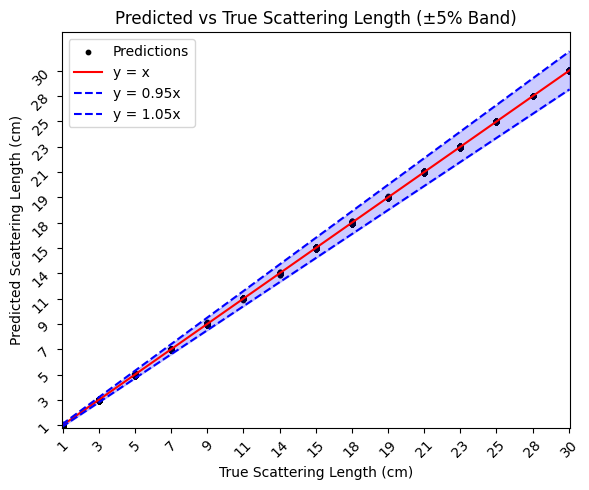

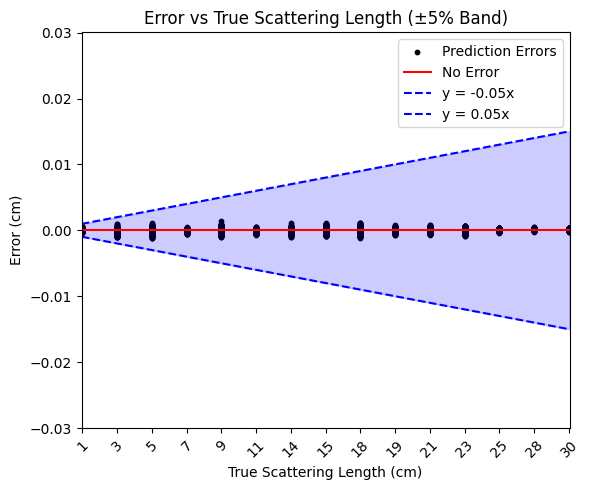

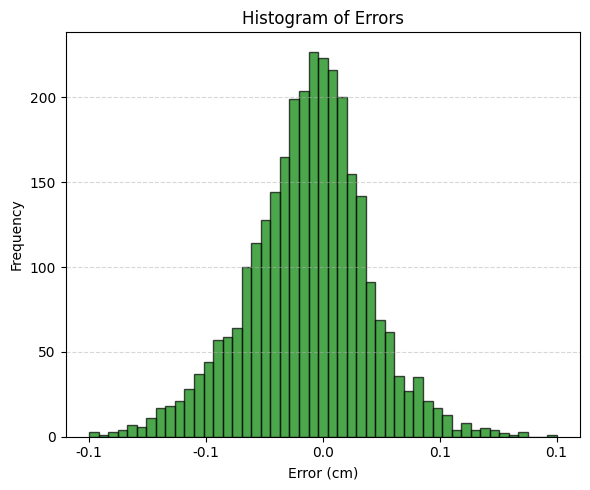

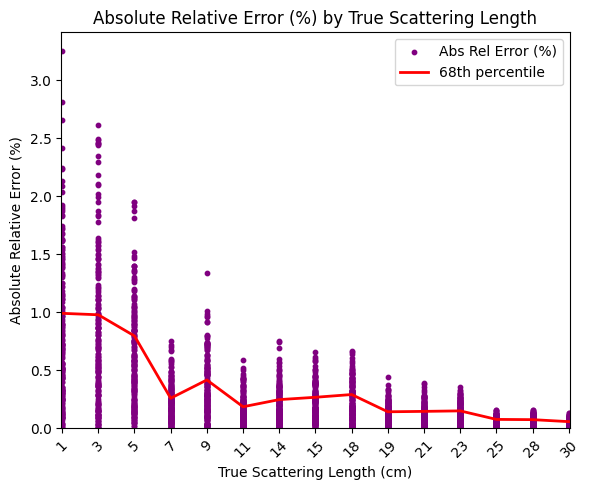

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------
# (가정) 
# true_vals, pred_vals, errors, abs_rel_errors, unique_true_labels, mn, mx
# 는 모두 "m" 단위 (예: 0.02, 0.04, …) 라고 합시다.
# ---------------------------------------------------

# ─────────────────────────────────────────────────────────────────────────────
# 1) Predicted vs True with ±5% Band (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax1 = plt.gca()

# (내부 연산은 m 단위 그대로)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx],
                 [0.95*mn, 0.95*mx],
                 [1.05*mn, 1.05*mx],
                 color='blue', alpha=0.2)

# 눈금(ticks)을 cm 단위로 변환해서 레이블에 표시
xticks_m = unique_true_labels         # 예: [0.02, 0.04, 0.06, …, 0.30]
xticks_cm = xticks_m * 100            # 예: [2, 4, 6, …, 30]
ax1.set_xticks(xticks_m)
ax1.set_xticklabels([f"{int(val)}" for val in xticks_cm], rotation=45)

# y축도 동일하게
yticks_m = unique_true_labels
yticks_cm = yticks_m * 100
ax1.set_yticks(yticks_m)
ax1.set_yticklabels([f"{int(val)}" for val in yticks_cm], rotation=45)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 2) Error vs True with ±5% Band (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax2 = plt.gca()

# 내부 연산은 m 단위 그대로
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx],
                 [-0.05*mn, -0.05*mx],
                 [0.05*mn, 0.05*mx],
                 color='blue', alpha=0.2)

# x축 눈금을 cm 단위로 변환
ax2.set_xticks(xticks_m)
ax2.set_xticklabels([f"{int(val)}" for val in xticks_cm], rotation=45)

ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 3) Histogram of Errors (50 bins) (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax3 = plt.gca()

# Error (m) → Histogram bin 설정
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')

ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")

# x축 눈금을 적절히 선택하여 cm 단위로 표시
# 예: errors.min()=−0.005, errors.max()=0.005 정도라면 [−0.005, −0.0025, 0, 0.0025, 0.005]
# 눈금마다 m→cm로 환산: [−0.5, −0.25, 0, 0.25, 0.5] (cm)
xticks_err_m = np.linspace(errors.min(), errors.max(), 5)
xticks_err_cm = xticks_err_m * 100
ax3.set_xticks(xticks_err_m)
ax3.set_xticklabels([f"{val:.1f}" for val in xticks_err_cm])

ax3.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 4) Absolute Relative Error (%) by True with 68th Percentile (눈금은 cm 단위로 표시)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 5))
ax4 = plt.gca()

ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 각 레이블(예: 0.02, 0.04, …)별로 68% percentile 계산
perc68s = []
for lbl_m in unique_true_labels:
    mask = np.isclose(true_vals, lbl_m, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 68)
        perc68s.append(perc68)
    else:
        perc68s.append(0)

ax4.plot(unique_true_labels, perc68s, color='red', lw=2, label='68th percentile')

# x축 눈금을 cm 단위로 변환
ax4.set_xticks(xticks_m)
ax4.set_xticklabels([f"{int(val)}" for val in xticks_cm], rotation=45)

ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(bottom=0)
ax4.legend()
plt.tight_layout()
plt.show()


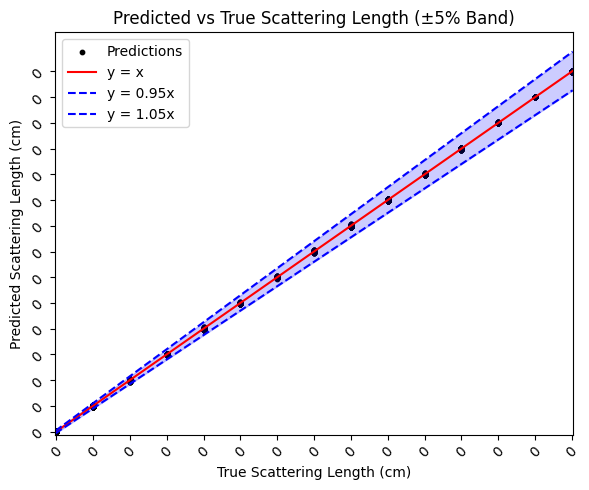

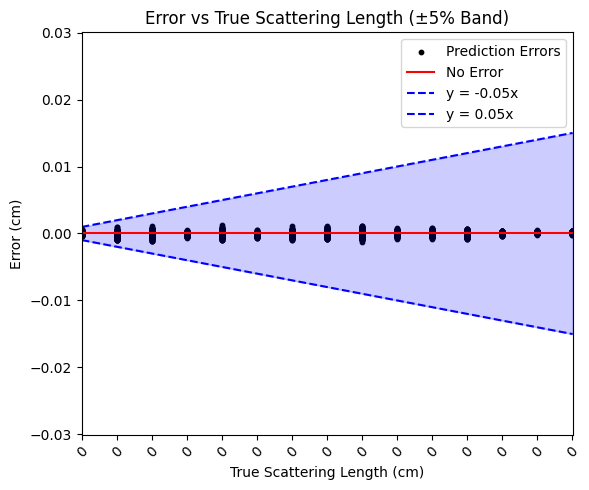

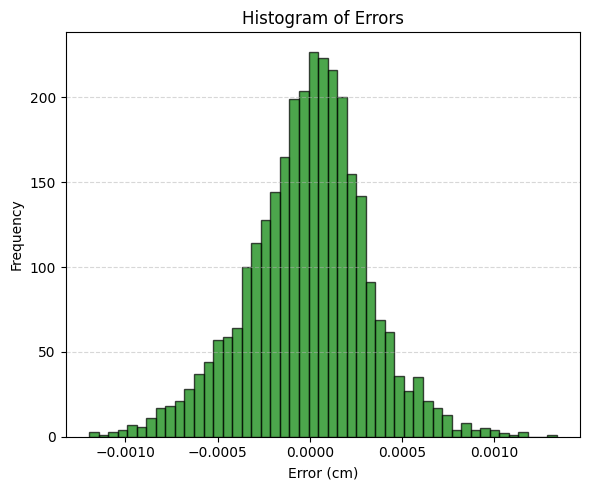

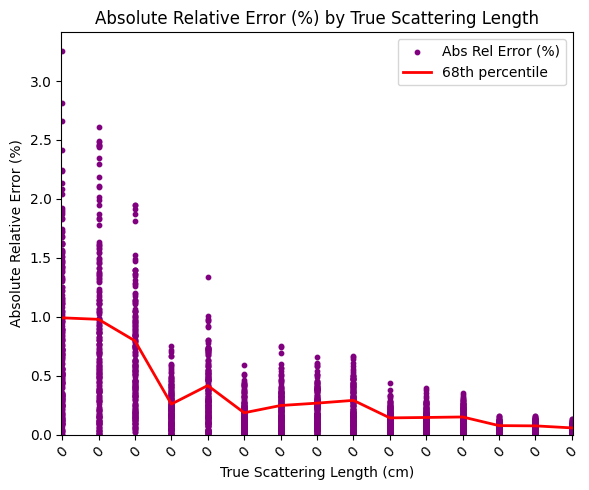

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# true_vals, pred_vals, errors, abs_rel_errors, unique_true_labels, mn, mx 는 모두 'cm' 단위로 가정합니다.

# (1) Predicted vs True with ±5% Band (단위: cm)
plt.figure(figsize=(6, 5))
ax1 = plt.gca()
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx],
                 [0.95*mn, 0.95*mx],
                 [1.05*mn, 1.05*mx],
                 color='blue', alpha=0.2)

# 틱 레이블을 'cm' 단위로 포맷 (예: 2.00 → "2")
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)
ax1.set_yticks(unique_true_labels)
ax1.set_yticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()
plt.tight_layout()
plt.show()

# (2) Error vs True with ±5% Band (단위: cm)
plt.figure(figsize=(6, 5))
ax2 = plt.gca()
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx],
                 [-0.05*mn, -0.05*mx],
                 [0.05*mn, 0.05*mx],
                 color='blue', alpha=0.2)

ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)

ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Histogram of Errors (단위: cm)
plt.figure(figsize=(6, 5))
ax3 = plt.gca()
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (4) Absolute Relative Error (%) by True with 68th Percentile (단위: cm)
plt.figure(figsize=(6, 5))
ax4 = plt.gca()
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 각 레이블마다 68% percentile 계산
perc68s = []
for lbl in unique_true_labels:
    mask = np.isclose(true_vals, lbl, atol=1e-6)
    if np.any(mask):
        perc68 = np.percentile(abs_rel_errors[mask], 68)
        perc68s.append(perc68)
    else:
        perc68s.append(0)

ax4.plot(unique_true_labels, perc68s, color='red', lw=2, label='68th percentile')

ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.0f}" for val in unique_true_labels], rotation=45)

ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(bottom=0)
ax4.legend()
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd

# pred_vals, true_vals: (N,) numpy array (이미 준비되어 있다고 가정)
# unique_labels: np.unique(true_vals) (라벨 후보, float/정수 상관없음)

results = []
for lbl in unique_true_labels:
    idx = np.where(true_vals == lbl)[0]
    errs = pred_vals[idx] - true_vals[idx]
    rel_errs = np.abs(errs / true_vals[idx]) * 100

    mean_err = np.mean(errs)
    mean_rel_err = np.mean(rel_errs)
    # 90% range: 5th–95th percentile (central 90%)
    range90_err = np.percentile(errs, [5, 95])
    range90_rel_err = np.percentile(rel_errs, [5, 95])
    range90_err_val = f"±{(range90_err[1]-range90_err[0])/2:.3f}"
    range90_rel_err_val = f"{(range90_rel_err[1]-range90_rel_err[0]):.3f}"

    results.append({
        "Scattering Length (cm)": lbl,
        "Mean Error (cm)": f"{mean_err:.3f}",
        "Mean Relative Error (%)": f"{mean_rel_err:.3f}",
        "90% Range of Error (cm)": range90_err_val,
        "90% Range of Relative Error (%)": range90_rel_err_val,
    })

# 전체(총계)도 계산
errs = pred_vals - true_vals
rel_errs = np.abs(errs / true_vals) * 100
mean_err = np.mean(errs)
mean_rel_err = np.mean(rel_errs)
range90_err = np.percentile(errs, [5, 95])
range90_rel_err = np.percentile(rel_errs, [5, 95])
range90_err_val = f"±{(range90_err[1]-range90_err[0])/2:.3f}"
range90_rel_err_val = f"{(range90_rel_err[1]-range90_rel_err[0]):.3f}"

results.append({
    "Scattering Length (cm)": "Total",
    "Mean Error (cm)": f"{mean_err:.3f}",
    "Mean Relative Error (%)": f"{mean_rel_err:.3f}",
    "90% Range of Error (cm)": range90_err_val,
    "90% Range of Relative Error (%)": range90_rel_err_val,
})

df = pd.DataFrame(results)
print(df)


   Scattering Length (cm) Mean Error (cm) Mean Relative Error (%)  \
0                    0.02           0.000                   0.800   
1                    0.04          -0.000                   0.795   
2                    0.06          -0.000                   0.613   
3                    0.08          -0.000                   0.223   
4                     0.1          -0.000                   0.333   
5                    0.12          -0.000                   0.153   
6                    0.14          -0.000                   0.199   
7                    0.16           0.000                   0.211   
8                    0.18          -0.000                   0.217   
9                     0.2           0.000                   0.113   
10                   0.22           0.000                   0.112   
11                   0.24          -0.000                   0.117   
12                   0.26           0.000                   0.056   
13                   0.28         